$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Neural Networks

Andy Clements

## Overview

Imported Libraries used throughout this notebook. Matplotlib was used for all of the plotting of data. Pandas and numpy were used to parse data into this notebook and manipulated to work with the given neuralnetworks.py, scaledconjugategradient.py, and mlutils.py which were used in lecture by Professor Chuck Anderson. Time was used to get some performance analysis for the required written functions.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pprint import pprint
import numpy as np
import neuralnetworks as nn
import scaledconjugategradient as scg
import mlutils as ml
from time import time

trainNNs is the main required function for this assignment. It is used to train and evaluate neural network models. It is designed to work with both regression problems and claassification problems depending on which one it is working on. The function takes as arguments `X` - a matrix of input data from a chosen data set, `T` - a matrix of all target data in that data set, `trainFraction` - the fraction to be used to partition X and T into training and testing sets, `hiddenLayerStructures` - the neural network models to evaluate, `numberRepetitions` - the number of times to train a neural network model, `numberIterationss` - the number of iterations to run the scaled conjugate gradient algorithm when a neural network is trained, and `classify` - a boolean to check whether or not to handle the call as a classification problem or not.

The function returns `all_results` which is a list with one element for each network model tested. Along with that network model, or network structure, is a list of training data performance for each repetition, a list of testing data performance for each repetition, and the number of seconds it took to run the `numberRepetitions` for the network model.

The function takes the `hiddenLayerStructures` and iterated through them gathering `all_results` as it goes. For each `rep` in `numberRepetitions` the following is timed. The mlutils.py library uses its partition function to randomly partition X and T into training and testing sets (`trainFraction` is used to partition the two). If the problem is to classify then it will construct a NeuralNetworkClassifier object using the number of columns in X as the number of inputs, ns as the number of structures used in the current `hiddenLayerStructurs` element, and the number of unique values in T as the number of outputs. If the problem is not to classify it will created a NeuralNetwork object using the columns in X as the number of inputs, the same number of structures indicated before, and the columns in T as the number of outputs. Once the neural network is created it will train it using the Xtrain and Ttrain partitions from mlutils.partition and the given `numberIterations`. The neural network will then be used to produce outputs for the training and testing sets. If the problem is to classify it will calculate the fraction of samples incorrectly classified for training and testing sets, otherwise it calculate the RMSE (root mean squared error) of training and testing sets. The timer is stopped and results are gathered and the function iterates the rest of the way through.

In [2]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, 
             numberIterations, classify=False):
    all_results = []
    # For each network structure given in hiddenLayerStructures
    for ns in hiddenLayerStructures:
        training_performance = []
        testing_performance = []
        startTime = time()
        # For numberRepetitions
        for rep in range(numberRepetitions):
            # Use ml.partition to randomly partition X and T into training and testing sets.
            Xtrain,Ttrain,Xtest,Ttest = \
                ml.partition(X,T,(trainFraction,1-trainFraction),classification=classify)
            # Create a neural network of the given structure
            if classify:
                nnet = nn.NeuralNetworkClassifier(X.shape[1], 
                                                  ns, 
                                                  len(np.unique(T)))
                                                  #T.shape[1]) # Might want to use len(np.unique(T)) for this
                                                              # This means the number of outputs will be different
            else:
                nnet = nn.NeuralNetwork(X.shape[1], ns, T.shape[1]) #rXows, network structure, Trows
            # Train it for numberIterations
            nnet.train(Xtrain,Ttrain,numberIterations) # precision not included, so defaults of zero used, 
                                             # which means will not terminate early
            # Use the trained network to produce outputs for the 
            ## training and for the testing sets
            Ytrain = nnet.use(Xtrain)
            Ytest = nnet.use(Xtest)
            # If classifying, calculate the fraction of samples incorrectly classified for 
            ## training and testing sets. 
            if classify:
                # CHECK HERE IF ISSUE WITH CALCULATE INCORRECTLY CLASSIFIED FRACTION IF SAMPLES
                training_performance.append(np.sum(Ytrain!=Ttrain)/len(Ttrain))
                testing_performance.append(np.sum(Ytest!=Ttest)/len(Ttest))
            else: # Otherwise, calculate the RMSE of training and testing sets.
                training_performance.append(np.sqrt(np.mean((Ytrain-Ttrain)**2)))
                testing_performance.append(np.sqrt(np.mean((Ytest-Ttest)**2)))
            # Add the training and testing performance to a collection (such as a list) for 
            ## this network structure
            '''Done above this without variables'''
        # Add to a collection of all results the hidden layer structure, lists of training 
        ##performance and testing performance, and seconds taken to do these repetitions.
        seconds = time() - startTime
        all_results.append([ns, training_performance, testing_performance, seconds])
    #return the collection of all results
    return all_results

`summarize(results)` returns a list of lists like results from `trainNNs` but with the list of training performances replaced by their mean and the list of testing performances replaced by their mean.

In [3]:
def summarize(results):
    summary = []
    for i in results:
        summary.append([i[0],
            np.mean(i[1]),
            np.mean(i[2]),
            i[3]])
    return summary

`bestNetwork(summary)` takes the output of `summarize(results)` and returns the best element of `results`, determined by the element that has the smallest test performance.

In [4]:
def bestNetwork(summary):
    sumdf = pd.DataFrame(summary)
    return list(sumdf.loc[sumdf[2].idxmin()])

`plotRegression` takes actual and predicted data and plots them out for analysis later on

In [5]:
def plotRegression(T, Y, title="Energy - Predicted vs True Appliance"):
    fig = plt.figure()
    plt.plot(T,Y,'g.')
    plt.ylabel('Predicted Appliance')
    plt.xlabel('True Appliance')
    plt.title(title)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels)
    plt.show()

## Examples

Example data set to show easy examples of the functions being used and how to select the best number of iterations and network structures

In [6]:
X = np.arange(10).reshape((-1,1))
T = X + 1 + np.random.uniform(-1, 1, ((10,1)))

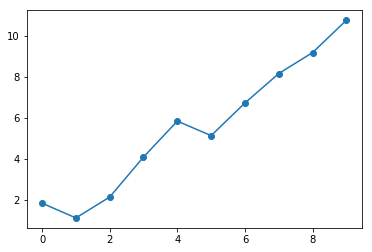

In [7]:
plt.plot(X, T, 'o-');

In [8]:
nnet = nn.NeuralNetwork(X.shape[1], 2, T.shape[1])
nnet.train(X, T, 100)
nnet.getErrorTrace()

array([0.70710678, 0.24423669, 0.1651861 , 0.16131226, 0.15839745,
       0.15025401, 0.14654371, 0.14458578, 0.14208104, 0.14175718,
       0.14070935, 0.13818339, 0.13773122, 0.13623516, 0.13620545,
       0.13616525, 0.13563169, 0.13544907, 0.13479852, 0.13414908,
       0.13383325, 0.1327033 , 0.13244086, 0.13201643, 0.13174066,
       0.13174066, 0.12670988, 0.12634012, 0.12005549, 0.11857126,
       0.11845365, 0.11802315, 0.11573215, 0.11549299, 0.11263449,
       0.11043019, 0.10722716, 0.10076503, 0.09987196, 0.09931442,
       0.09895198, 0.09830641, 0.09743491, 0.09719523, 0.09700016,
       0.09628498, 0.09556819, 0.09496124, 0.09441282, 0.08915811,
       0.08790412, 0.08760645, 0.08718345, 0.08608626, 0.08420831,
       0.08415644, 0.08371049, 0.08321131, 0.08312428, 0.08304156,
       0.08298227, 0.08212868, 0.08206671, 0.08196027, 0.08153644,
       0.08137671, 0.08133045, 0.081253  , 0.08065447, 0.08057037,
       0.08047202, 0.07958198, 0.07949143, 0.07945261, 0.07927

In [9]:
nnet = nn.NeuralNetwork(X.shape[1], [5, 5, 5], T.shape[1])
nnet.train(X, T, 100)
nnet.getErrorTrace()

array([0.70710678, 0.45951524, 0.45951524, 0.45951524, 0.25181455,
       0.21008035, 0.15956231, 0.15815941, 0.15583729, 0.15389745,
       0.1444135 , 0.14379568, 0.14323907, 0.14285012, 0.13863   ,
       0.13843761, 0.13689665, 0.1356468 , 0.13557782, 0.13557782,
       0.13557782, 0.13557782, 0.13521935, 0.12646714, 0.12539229,
       0.1232501 , 0.12323603, 0.12281374, 0.12281374, 0.12281374,
       0.12281374, 0.12281374, 0.11446273, 0.11417335, 0.1132292 ,
       0.11203641, 0.11155634, 0.11031886, 0.10846321, 0.10400346,
       0.10312851, 0.10290687, 0.10271131, 0.10267546, 0.10263088,
       0.10239114, 0.10181873, 0.10162601, 0.1015476 , 0.10119075,
       0.10087044, 0.099347  , 0.09891105, 0.09877974, 0.09856133,
       0.0971073 , 0.09700202, 0.09405385, 0.09281013, 0.08773625,
       0.08723363, 0.08473064, 0.0802198 , 0.08007218, 0.07966978,
       0.07958549, 0.07955392, 0.07792204, 0.07749573, 0.07631334,
       0.07450805, 0.07424608, 0.07401452, 0.07301244, 0.07290

In [10]:
results = trainNNs(X, T, 0.8, [2, 10, [10, 10]], 5, 100, classify=False)
results

[[2,
  [0.30659919357431,
   0.20925749531396576,
   0.635906797324682,
   0.636779898682868,
   0.3482577311768003],
  [0.6318318276392216,
   1.4685868799267119,
   0.8407510855032548,
   0.3969460233010682,
   0.8991695621042909],
  0.07497262954711914],
 [10,
  [0.013734105534768013,
   0.2795206141503955,
   0.16676446742959528,
   0.16853961161620018,
   0.1350304977903605],
  [1.06870946186851,
   0.7989190592036907,
   1.5378805254397494,
   0.9086925095435168,
   1.1615600489382747],
  0.08193755149841309],
 [[10, 10],
  [0.10221997319934184,
   0.16218029691033978,
   0.2005690393234091,
   0.11309078594417729,
   0.13512541019281424],
  [1.0411036036698005,
   1.1923526617131446,
   0.7163921335437438,
   0.8910896346757554,
   1.0667408714887372],
  0.11794424057006836]]

In [11]:
results = trainNNs(X, T, 0.8, [0, 1, 2, 10, [10, 10], [5, 5, 5, 5], [2]*5], 50, 100, classify=False)

In [12]:
summarize(results)

[[0, 0.6006399312766988, 0.8473922193879208, 0.018991470336914062],
 [1, 0.5655338173567238, 0.9092532071184252, 0.6866073608398438],
 [2, 0.42741744818625726, 1.0989402236457537, 0.7705602645874023],
 [10, 0.20888918455415365, 0.9897834607160588, 0.765561580657959],
 [[10, 10], 0.18796951154329275, 0.9398768002378559, 1.112377643585205],
 [[5, 5, 5, 5], 0.369370767988905, 0.9163491293390326, 1.5031335353851318],
 [[2, 2, 2, 2, 2], 0.5275009725953089, 0.9017389538745203, 1.6200716495513916]]

In [13]:
best = bestNetwork(summarize(results))
print(best)
print('Hidden Layers {} Average RMSE Training {:.2f} Testing {:.2f} Took {:.2f} seconds'.format(*best))

[0, 0.6006399312766988, 0.8473922193879208, 0.018991470336914062]
Hidden Layers 0 Average RMSE Training 0.60 Testing 0.85 Took 0.02 seconds


The best neural network was one with no hidden layers. That means that the lowest test performance for `summarize(results)` was in that network structure. 

# Data for Regression Experiment

The data used is from the UCI Machine Learning Repository. I used pandas to read in the energy file from the url given here: the [Appliances energy prediction](http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction) data.


In [14]:
# CSV file
csv_file = 'energydata_complete.csv'
# URL if CSV isn't downloaded
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv'
# read cvs with pandas read_csv from the URL. Use columns 1-27 and delimit by a comma
df = pd.read_csv(url, delimiter=',', usecols=range(1,27))
#copy the data so manipulations happen to the copy in case I need df later.
data = df.copy()

The column names and number of columns

In [16]:
names = data.columns.values
names, len(names)

(array(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3',
        'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
        'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out',
        'Windspeed', 'Visibility', 'Tdewpoint'], dtype=object), 26)

Shape of the input data before I slice into it

In [17]:
data.shape

(19735, 26)

In pandas you can slice by clumn name or index so I tried both

In [22]:
test_df_slicing = data.loc[:, ['Appliances', 'lights']]
test_df_slicing.head(3)

Appliances  lights
0          60      30
1          60      30
2          50      30

In [23]:
Xenergy = data.iloc[:, 2:]
Tenergy = data.iloc[:,:2]

In [24]:
Xenergy.head(3)

T1       RH_1    T2       RH_2     T3       RH_3         T4       RH_4  \
0  19.89  47.596667  19.2  44.790000  19.79  44.730000  19.000000  45.566667   
1  19.89  46.693333  19.2  44.722500  19.79  44.790000  19.000000  45.992500   
2  19.89  46.300000  19.2  44.626667  19.79  44.933333  18.926667  45.890000   

          T5   RH_5    ...        T8       RH_8         T9   RH_9     T_out  \
0  17.166667  55.20    ...      18.2  48.900000  17.033333  45.53  6.600000   
1  17.166667  55.20    ...      18.2  48.863333  17.066667  45.56  6.483333   
2  17.166667  55.09    ...      18.2  48.730000  17.000000  45.50  6.366667   

   Press_mm_hg  RH_out  Windspeed  Visibility  Tdewpoint  
0        733.5    92.0   7.000000   63.000000        5.3  
1        733.6    92.0   6.666667   59.166667        5.2  
2        733.7    92.0   6.333333   55.333333        5.1  

[3 rows x 24 columns]

In [27]:
Tenergy.head(3)

Appliances  lights
0          60      30
1          60      30
2          50      30

Pandas is built on top of numpy so shape and other functions should look the same

In [28]:
#((19735, 24), (19735, 2))
Xenergy.shape, Tenergy.shape

((19735, 24), (19735, 2))

In [29]:
Tenergy.columns.values.tolist()

['Appliances', 'lights']

In [32]:
Xenergy.columns.values

array(['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5',
       'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9',
       'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint'], dtype=object)

Now that I am done using pandas to slice and clean the data I want to turn them back into numpy structures so they work with the imported code and their functions.

In [33]:
Xenergy = np.asarray(Xenergy)
Tenergy = np.asarray(Tenergy)

## Training several neural networks on all this data

Given the task: Train several neural networks on all of this data for 100 iterations.  Plot the error trace (nnet.getErrorTrace()) to help you decide now many iterations might be needed.  I will train them until I see the error leveling out i.e. the slope becomes minimally changing.

Now to use my `trainNNs`, `summarize`, and `bestNetwork` functions on this data to investigate various network sizes. (at least 100 repetitions)

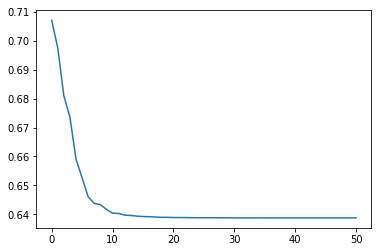

In [35]:
nnet = nn.NeuralNetwork(Xenergy.shape[1], 0, Tenergy.shape[1])
nnet.train(Xenergy, Tenergy, 100)
plt.plot(nnet.getErrorTrace(), '-');

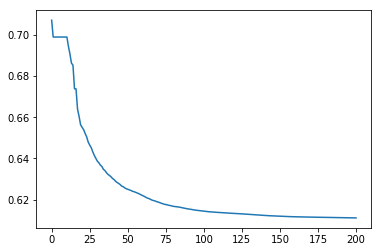

In [39]:
nnet = nn.NeuralNetwork(Xenergy.shape[1], 5, Tenergy.shape[1])
nnet.train(Xenergy, Tenergy, 200)
plt.plot(nnet.getErrorTrace(), '-');

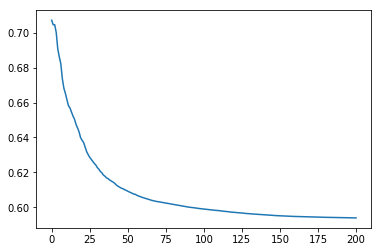

In [37]:
nnet = nn.NeuralNetwork(Xenergy.shape[1], [5,5], Tenergy.shape[1])
nnet.train(Xenergy, Tenergy, 200)
plt.plot(nnet.getErrorTrace(), '-');

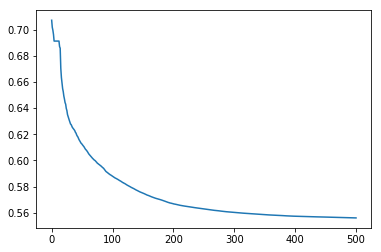

In [44]:
nnet = nn.NeuralNetwork(Xenergy.shape[1], [10,10], Tenergy.shape[1])
nnet.train(Xenergy, Tenergy, 500)
plt.plot(nnet.getErrorTrace(), '-');

I would keep going to get the slope at the end even closer to zero but in the interest of the 10 structures I won't test all of them for much higher than 750

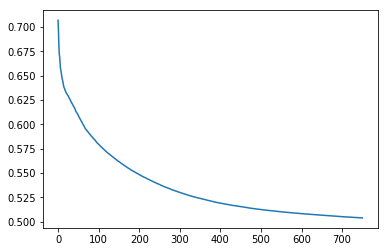

In [43]:
nnet = nn.NeuralNetwork(Xenergy.shape[1], 50, Tenergy.shape[1])
nnet.train(Xenergy, Tenergy, 750)
plt.plot(nnet.getErrorTrace(), '-');

This network model could STILL use more repetitions to get even better results.

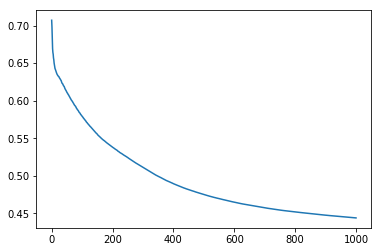

In [42]:
nnet = nn.NeuralNetwork(Xenergy.shape[1], 100, Tenergy.shape[1])
nnet.train(Xenergy, Tenergy, 1000)
plt.plot(nnet.getErrorTrace(), '-');

## Profiling four hidden network structures

Based on inputs from the original assignment example I ddi some profiling to check where time was being spent

In [124]:
import cProfile
cp = cProfile.Profile()
cp.enable()
results = trainNNs(Xenergy, Tenergy, 0.8, [0, 5, [5,5], [10, 10]], 10, 100)
cp.disable()

Interpreting this performance data I can tell the most time spent is with the backward pass. 3:1 as opposed to the forward pass. The rest of the time was spent using the dot product in numpy to calculate as it went. The most expensive per call was scaledconjugategradient.py (scg) but was called the fewest by far. This is actually good because I can tell if we can optimize the backward pass and dot product (easy to do if used on the GPU) we can cut performance down and use better network structures in a much more timely manner since the data can get large and time can be consuming.

In [46]:
import pstats
stats = pstats.Stats(cp)
stats.strip_dirs().sort_stats('tottime').print_stats(8)

         633227 function calls in 71.053 seconds

   Ordered by: internal time
   List reduced from 73 to 8 due to restriction <8>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     6776   32.405    0.005   47.291    0.007 neuralnetworks.py:125(_backward_pass)
    89799   20.766    0.000   20.766    0.000 {built-in method numpy.core.multiarray.dot}
    10416   11.442    0.001   17.836    0.002 neuralnetworks.py:110(_forward_pass)
     6776    2.386    0.000   61.572    0.009 neuralnetworks.py:71(gradF)
       40    1.465    0.037   70.136    1.753 scaledconjugategradient.py:26(scg)
      120    0.332    0.003    0.332    0.003 neuralnetworks.py:142(_standardizeX)
     3560    0.248    0.000    6.898    0.002 neuralnetworks.py:66(objectiveF)
     3880    0.222    0.000    0.222    0.000 {method 'reduce' of 'numpy.ufunc' objects}




In [47]:
bestNetwork(summarize(results))

[[10, 10], 63.12462616453526, 63.57949978435205, 34.12751340866089]

## Testing 10 different hidden layer structures

Test at least 10 different hidden layer structures.  Larger numbers of layers and units may do the best on training data, but not on testing data. Why?

In [48]:
results_10_layers = trainNNs(Xenergy, Tenergy, 0.8, 
                   [1, 5, [5, 5], [10, 10],[1,2,3,4],15,20,[1,5,10,15,20],[2,2,2,2],[20,20,20,20]], 
                   10, 350)

In [49]:
summary_10_layers = summarize(results_10_layers)
summary_10_layers

[[1, 70.6632500033939, 69.4138663417843, 46.69731783866882],
 [5, 64.78335900946543, 65.91148540812893, 56.844542503356934],
 [[5, 5], 63.99879078068832, 64.94717769700208, 69.36939024925232],
 [[10, 10], 59.48062685125249, 63.673752162274276, 123.4345211982727],
 [[1, 2, 3, 4], 70.26799687401568, 70.04216572157645, 66.99576473236084],
 [15, 61.96638990530762, 63.38280813549161, 103.92664051055908],
 [20, 60.72490621675011, 62.684838118585866, 125.31644654273987],
 [[1, 5, 10, 15, 20],
  70.08747534806642,
  70.60093921459746,
  231.51573657989502],
 [[2, 2, 2, 2], 66.23117289202136, 66.51176124750296, 62.0335795879364],
 [[20, 20, 20, 20], 49.77011521052817, 59.85194474683389, 358.9040699005127]]

In [50]:
bn_10_layers = bestNetwork(summary_10_layers)
bn_10_layers

[[20, 20, 20, 20], 49.77011521052817, 59.85194474683389, 358.9040699005127]

## Training a network with the best hidden layer structure
The following networks were trained using my best hidden layer structure from above. These were used to run partitions on the lights column and appliances columns of the target data matrix.
For the testing data, the plots below show the predicted and actual `Appliances` energy use, and the predicted and actual `lights` energy use, in two separate plots.

In [51]:
data.columns.values

array(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3',
       'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out',
       'Windspeed', 'Visibility', 'Tdewpoint'], dtype=object)

In [52]:
t_appliances = data.loc[:, ['Appliances']]
t_lights = data.loc[:, ['lights']]
x_appliances = data.loc[:, ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3',
       'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out',
       'Windspeed', 'Visibility', 'Tdewpoint']]
x_lights = data.loc[:, ['Appliances', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3',
       'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out',
       'Windspeed', 'Visibility', 'Tdewpoint']]

x_appliances, t_appliances = np.asarray(x_appliances),np.asarray(t_appliances)
x_lights, t_lights = np.asarray(x_lights),np.asarray(t_lights)

In [53]:
trainFraction=0.8

I see that the appliances energy use was wide ranging. The more true appliance energy use the worse it was at predicting the energy based on the expected collection of points. You can see it attempting to follow the 45 degree angle from bottom left to top right but it was very wide ranging as time went on. I think this shows that the sample data was not enough to make a confident prediction. The lights energy use was even more wide ranging. Even when structured more at an expected increased slope the values wer still wide ranging for each prediction.

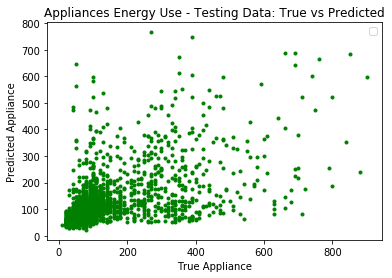

In [120]:
Xatrain,Tatrain,Xatest,Tatest = ml.partition(x_appliances,t_appliances,(trainFraction,1-trainFraction),classification=False)
nnet = nn.NeuralNetwork(x_appliances.shape[1], [20,20,20,20], t_appliances.shape[1])
nnet.train(Xatrain,Tatrain,350)
Yatrain = nnet.use(Xatrain)
Yatest = nnet.use(Xatest)
plotRegression(Tatest, Yatest,title="Appliances Energy Use - Testing Data: True vs Predicted")

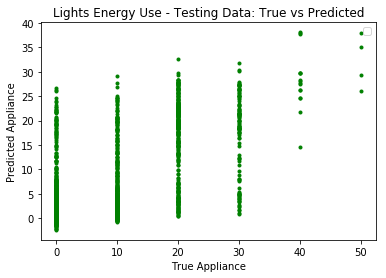

In [121]:
Xltrain,Tltrain,Xltest,Tltest = ml.partition(x_lights,t_lights,(trainFraction,1-trainFraction),classification=False)
nnet = nn.NeuralNetwork(x_lights.shape[1], [20,20,20,20], t_lights.shape[1])
nnet.train(Xltrain,Tltrain,350)
Yltrain = nnet.use(Xltrain)
Yltest = nnet.use(Xltest)
plotRegression(Tltest, Yltest,title="Lights Energy Use - Testing Data: True vs Predicted")

In [125]:
# Use ml.partition to randomly partition X and T into training and testing sets.
Xtrain,Ttrain,Xtest,Ttest = \
    ml.partition(Xenergy,Tenergy,(trainFraction,1-trainFraction),classification=False)

In [126]:
nnet = nn.NeuralNetwork(Xenergy.shape[1], [20,20,20,20], Tenergy.shape[1]) #rXows, network structure, Trows

In [127]:
nnet.train(Xtrain,Ttrain,400) # precision not included, so defaults of zero used, 
                                 # which means will not terminate early

NeuralNetwork(24, [20, 20, 20, 20], 2)
   Network was trained for 401 iterations. Final error is 0.4477484915870939.

In [128]:
Ytrain = nnet.use(Xtrain)
Ytest = nnet.use(Xtest) #Ttrain?
Ytrain.shape, Ytest.shape, Ttest.shape

((15788, 2), (3947, 2), (3947, 2))

## Plot Energy testing and training data for Appliances and analyze

I wanted to show the target data together plotted versus the sample data. These were form the sample ran above but with 400 repetitions. It shows more repetitions gather the points a little closer to the expected range but the sample data was still not enough to make an accurate prediction.

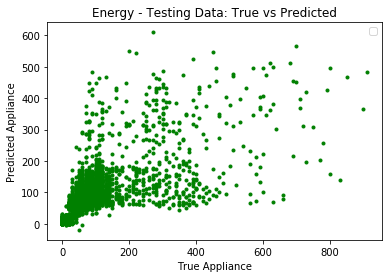

In [129]:
plotRegression(Ttest, Ytest,title="Energy - Testing Data: True vs Predicted")

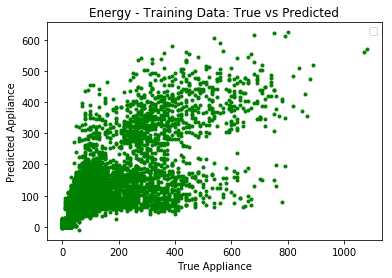

In [130]:
plotRegression(Ttrain, Ytrain,title="Energy - Training Data: True vs Predicted")

# Data for Classification Experiment

Data extracted using pandas from the UCI Machine Learning Repository, Anuran Calls (MFCCs) http://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29 data.
I will try to predict the species. In order to convert the species to a target class, as an integer. I used `pandas` function `uynique` to create a mapping of the unique species to different nominal column values. 

In [69]:
# CSV file
csv_file = 'Frogs_MFCCs.csv'
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran Calls (MFCCs).zip'

In [70]:
# read cvs with pandas read_csv
df = pd.read_csv(csv_file, delimiter=',', usecols=range(1,25))
data = df.copy()

In [71]:
Xanuran = np.array(data.iloc[:,:21])

In [72]:
data.Species.unique()

array(['AdenomeraAndre', 'Ameeregatrivittata', 'AdenomeraHylaedactylus',
       'HylaMinuta', 'HypsiboasCinerascens', 'HypsiboasCordobae',
       'LeptodactylusFuscus', 'OsteocephalusOophagus',
       'Rhinellagranulosa', 'ScinaxRuber'], dtype=object)

In [73]:
mapping_dict = {
    "Species":{
        'AdenomeraAndre': 0, 
        'Ameeregatrivittata': 1, 
        'AdenomeraHylaedactylus': 2,
       'HylaMinuta':3 , 
        'HypsiboasCinerascens': 4, 
        'HypsiboasCordobae': 5,
       'LeptodactylusFuscus': 6, 
        'OsteocephalusOophagus': 7,
       'Rhinellagranulosa': 8, 
        'ScinaxRuber':9
    }
}

In [74]:
Tanuran = data.loc[:,['Species']]
Tanuran.head(3)

Species
0  AdenomeraAndre
1  AdenomeraAndre
2  AdenomeraAndre

In [75]:
Tanuran = np.array(Tanuran.replace(mapping_dict), dtype=int)

In [76]:
Xanuran.shape, Tanuran.shape

((7195, 21), (7195, 1))

In [77]:
Xanuran[:2,:]

array([[ 0.1529363 , -0.1055859 ,  0.20072191,  0.31720106,  0.26076385,
         0.10094464, -0.1500626 , -0.17112763,  0.12467644,  0.18865415,
        -0.07562172, -0.15643593,  0.08224512,  0.13575204, -0.02401665,
        -0.10835111, -0.07762252, -0.0095678 ,  0.05768398,  0.11868014,
         0.01403845],
       [ 0.17153426, -0.09897474,  0.26842522,  0.33867186,  0.2683531 ,
         0.06083509, -0.22247464, -0.20769267,  0.17088287,  0.27095828,
        -0.09500394, -0.25434147,  0.02278623,  0.1633201 ,  0.01202228,
        -0.09097401, -0.05650952, -0.03530336,  0.02013996,  0.08226299,
         0.02905574]])

In [78]:
Tanuran[:2], len(np.unique(Tanuran))

(array([[0],
        [0]]), 10)

In [79]:
for i in range(10):
    print('{} samples in class {}'.format(np.sum(Tanuran==i), i))

672 samples in class 0
542 samples in class 1
3478 samples in class 2
310 samples in class 3
472 samples in class 4
1121 samples in class 5
270 samples in class 6
114 samples in class 7
68 samples in class 8
148 samples in class 9


In [80]:
results = trainNNs(Xanuran, Tanuran, 0.8, [0, 5, [5, 5]], 5, 100, classify=True)

In [81]:
summarize(results)

[[0, 0.026511466296038916, 0.035024322446143154, 1.2233009338378906],
 [5, 0.03728283530229326, 0.044892286309937454, 2.88735294342041],
 [[5, 5], 0.06615705350938152, 0.07810979847116054, 3.277127981185913]]

In [82]:
bestNetwork(summarize(results))

[0, 0.026511466296038916, 0.035024322446143154, 1.2233009338378906]

## Investigation into different Hidden layer structures

I tested at least 10 different hidden layer structures. Then trained another network with my best hidden layer structure on 0.8 of the data and use the trained network on the testing data (the remaining 0.2 of the date). 

The Plots at the bottom reflect the predicted and actual `Species` for the testing data as an integer.

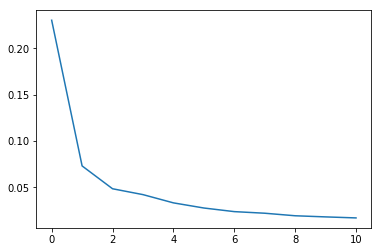

In [83]:
nnet = nn.NeuralNetworkClassifier(Xanuran.shape[1], 0, len(np.unique(Tanuran)))
nnet.train(Xanuran, Tanuran, 10)
plt.plot(nnet.getErrorTrace(), '-')

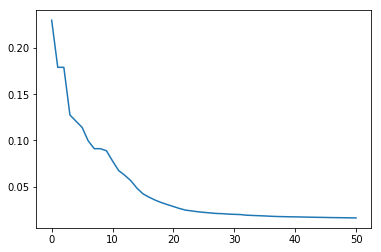

In [84]:
nnet = nn.NeuralNetworkClassifier(Xanuran.shape[1], 5, len(np.unique(Tanuran)))
nnet.train(Xanuran, Tanuran, 50)
plt.plot(nnet.getErrorTrace(), '-')

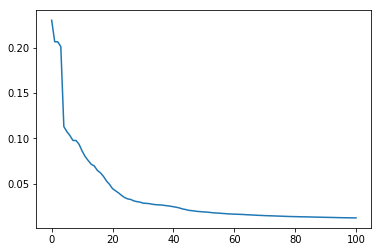

In [85]:
nnet = nn.NeuralNetworkClassifier(Xanuran.shape[1], [5,5], len(np.unique(Tanuran)))
nnet.train(Xanuran, Tanuran, 100)
plt.plot(nnet.getErrorTrace(), '-')

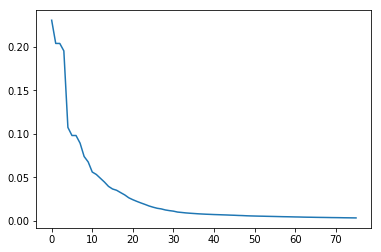

In [86]:
nnet = nn.NeuralNetworkClassifier(Xanuran.shape[1], [10,10], len(np.unique(Tanuran)))
nnet.train(Xanuran, Tanuran, 75)
plt.plot(nnet.getErrorTrace(), '-')

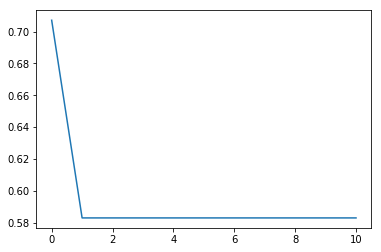

In [87]:
nnet = nn.NeuralNetwork(Xanuran.shape[1], 50, len(np.unique(Tanuran)))
nnet.train(Xanuran, Tanuran, 10)
plt.plot(nnet.getErrorTrace(), '-')

I wanted to test a small size of hidden layer structures to see what it would determine was best

In [88]:
results_small = trainNNs(Xanuran, Tanuran, 0.8, [0, 5, [5, 5], [10,10], 50], 5, 75, True)

In [89]:
summary = summarize(results_small)
summary

[[0, 0.031584433634468376, 0.036692147324530924, 0.8924896717071533],
 [5, 0.03561501042390549, 0.04739402362751911, 2.3736441135406494],
 [[5, 5], 0.06525364836692146, 0.07129951355107714, 2.5945193767547607],
 [[10, 10], 0.012022237665045172, 0.02640722724113968, 3.441035032272339],
 [50, 0.0, 0.011535788742182073, 9.375645875930786]]

In [90]:
bestNetwork(summary)

[50, 0.0, 0.011535788742182073, 9.375645875930786]

Continuing my investigation...

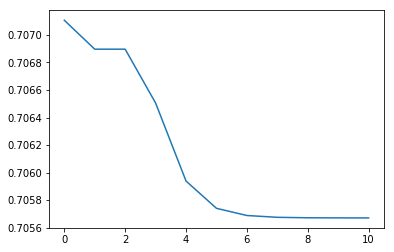

In [91]:
nnet = nn.NeuralNetwork(Xanuran.shape[1], [1,2,3,4], len(np.unique(Tanuran)))
nnet.train(Xanuran, Tanuran, 10)
plt.plot(nnet.getErrorTrace(), '-')

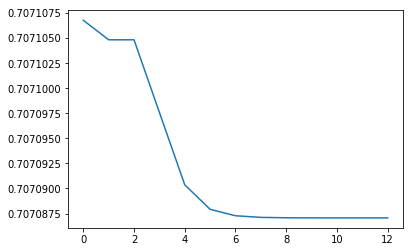

In [107]:
nnet = nn.NeuralNetwork(Xanuran.shape[1], [4,3,2,1], len(np.unique(Tanuran)))
nnet.train(Xanuran, Tanuran, 12)
plt.plot(nnet.getErrorTrace(), '-')

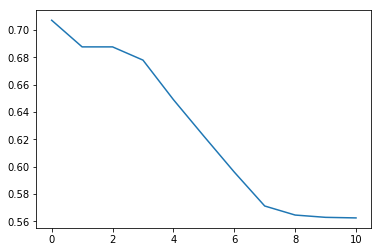

In [93]:
nnet = nn.NeuralNetwork(Xanuran.shape[1], [1,5,10,15,20], len(np.unique(Tanuran)))
nnet.train(Xanuran, Tanuran, 10)
plt.plot(nnet.getErrorTrace(), '-')

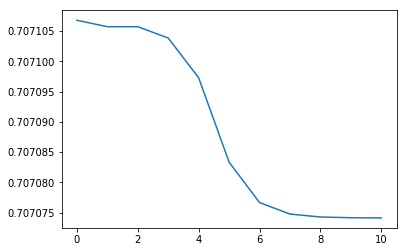

In [94]:
nnet = nn.NeuralNetwork(Xanuran.shape[1], [2,2,2,2], len(np.unique(Tanuran)))
nnet.train(Xanuran, Tanuran, 10)
plt.plot(nnet.getErrorTrace(), '-')

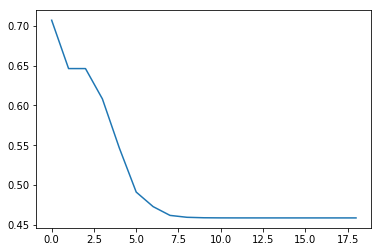

In [108]:
nnet = nn.NeuralNetwork(Xanuran.shape[1], [20,20,20,20], len(np.unique(Tanuran)))
nnet.train(Xanuran, Tanuran, 18)
plt.plot(nnet.getErrorTrace(), '-')

In [96]:
results_10_layers = trainNNs(Xanuran, Tanuran, 0.8, 
                   [0, 5, [5, 5], [10, 10],[1,2,3,4],50,[4,3,2,1],[1,5,10,15,20],[2,2,2,2],[20,20,20,20]], 
                   10, 100, True)

In [97]:
summary_10_layers = summarize(results_10_layers)
summary_10_layers

[[0, 0.026737317581653923, 0.03703961084086171, 2.3716471195220947],
 [5, 0.037334954829742875, 0.045726198749131336, 6.459310054779053],
 [[5, 5], 0.07223766504517025, 0.0817234190410007, 7.5786731243133545],
 [[10, 10], 0.0055072967338429465, 0.02355802640722724, 9.24472188949585],
 [[1, 2, 3, 4], 0.3455177206393329, 0.34920083391243917, 7.183897495269775],
 [50, 0.0, 0.01063238359972203, 23.241729497909546],
 [[4, 3, 2, 1], 0.35837387074357185, 0.3587908269631689, 7.950460195541382],
 [[1, 5, 10, 15, 20],
  0.25314454482279364,
  0.25580264072272413,
  16.330676317214966],
 [[2, 2, 2, 2], 0.3128214037526059, 0.31535788742182075, 6.518276929855347],
 [[20, 20, 20, 20],
  0.0029360667129951354,
  0.023905489923558027,
  23.288702487945557]]

In [98]:
bn_10_layers = bestNetwork(summary_10_layers)
bn_10_layers

[50, 0.0, 0.01063238359972203, 23.241729497909546]

Now that I have my best network structure from what I tested above, I can use it to plot the predicted vs actual data for Anuran Calls.

In [131]:
# Use ml.partition to randomly partition X and T into training and testing sets.
Xtrain,Ttrain,Xtest,Ttest = \
    ml.partition(Xanuran,Tanuran,(0.8,0.2),classification=True)

In [132]:
nnet = nn.NeuralNetworkClassifier(Xanuran.shape[1], 50, len(np.unique(Tanuran))) #rXows, network structure, Trows

In [133]:
nnet.train(Xtrain,Ttrain,75) # precision not included, so defaults of zero used, 
                                 # which means will not terminate early

NeuralNetwork(21, [50], 10)
   Network was trained for 75 iterations. Final error is 9.319415495957233e-07.

In [134]:
Ytrain = nnet.use(Xtrain)
Ytest = nnet.use(Xtest) #Ttrain?
Ytrain.shape, Ytest.shape, Ttest.shape

((5756, 1), (1439, 1), (1439, 1))

## Plot testing and training data for target "Species" in the Anuran Calls MFCC data

Without connecting the dots on the plot, I can see the range is very close to the expected slope on the testing data. The species were printed as mapped from above

{'Species': {'AdenomeraAndre': 0, 'Ameeregatrivittata': 1, 'AdenomeraHylaedactylus': 2, 'HylaMinuta': 3, 'HypsiboasCinerascens': 4, 'HypsiboasCordobae': 5, 'LeptodactylusFuscus': 6, 'OsteocephalusOophagus': 7, 'Rhinellagranulosa': 8, 'ScinaxRuber': 9}}


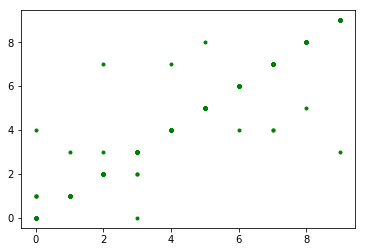

In [140]:
print(str(mapping_dict))
plt.plot(Ttest, Ytest,"g.")

The plot of the training data on the species matched up exactly with the expected slope. The True verse predicted plot shows the sample data used and target data used was perfect for this data set.

{'Species': {'AdenomeraAndre': 0, 'Ameeregatrivittata': 1, 'AdenomeraHylaedactylus': 2, 'HylaMinuta': 3, 'HypsiboasCinerascens': 4, 'HypsiboasCordobae': 5, 'LeptodactylusFuscus': 6, 'OsteocephalusOophagus': 7, 'Rhinellagranulosa': 8, 'ScinaxRuber': 9}}


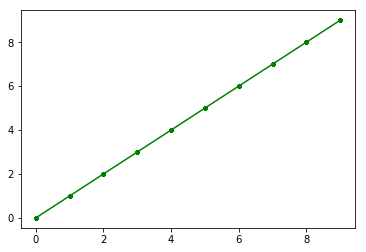

In [141]:
print(str(mapping_dict))
plt.plot(Ttrain, Ytrain,"g.-")#title="Frogs_MFCC - Species Training Data: True vs Predicted")

# Testing the functions

In [113]:
%run -i "A5grader.py"


======================= Code Execution =======================


Testing summarize([[[1,1], [1.2, 1.3, 1.4], [2.2, 2.3, 2.4], 0.5], [[2,2,2], [4.4, 4.3, 4.2], [6.5, 6.4, 6.3], 0.6]])

--- 10/10 points. Correctly returned [[[1, 1], 1.3, 2.3000000000000003, 0.5], [[2, 2, 2], 4.3, 6.3999999999999995, 0.6]]

Testing bestNetwork([[[1, 1], 1.3, 2.3, 0.5], [[2, 2, 2], 4.3, 1.3, 0.6]])

--- 10/10 points. Correctly returned [[2, 2, 2], 4.3, 1.3, 0.6]

X = np.random.uniform(-1, 1, (100, 3))
T = np.hstack(((X**2 - 0.2*X**3).sum(axis=1,keepdims=True),
               (np.sin(X)).sum(axis=1,keepdims=True)))
result = trainNNs(X, T, 0.7, [0, 5, 10, [20, 20]], 10, 100, False)

--- 20/20 points. Correct.

Testing bestNetwork(summarize(result))

--- 20/20 points. You correctly found that network [20, 20] is best.

C:\Users\Draqolv\Downloads\cs440\cs440\Jupyter Notebook Viewer_files Execution Grade is 60 / 60

======================= The regression data set =======================

--- _ / 5 points. Read

<Figure size 432x288 with 0 Axes>

In [ ]:
!cat neuralnetwork